# LKJCorr and LKJCov in pymc

While continuing to deep dive on covariance priors following my [prior post](/data%20science/statistics/cov_matrix_weirdness/), I investigated implementations in `pymc`. I played around with the `LKJcorr` and `LKJcov` functions (named for the authors Lewandowskia, Kurowicka, and Joe). There's already great explanations out there where you can take a look.

- [Original paper](https://www.sciencedirect.com/science/article/pii/S0047259X09000876?via%3Dihub)
- [Explanation from Distribution Explorer](https://distribution-explorer.github.io/multivariate_continuous/lkj.html)
- [Stan example implementation](https://yingqijing.medium.com/lkj-correlation-distribution-in-stan-29927b69e9be)
- [Why LKJcorr is a good prior for correlation matrix?](https://stats.stackexchange.com/questions/304684/why-lkjcorr-is-a-good-prior-for-correlation-matrix)
- [PyMC documentation on covariance priors](https://docs.pymc.io/en/v3/pymc-examples/examples/case_studies/LKJ.html)

I felt those references were more useful after I got my hands dirty. I learned by continuing to try some of McElreath's Statistical Rethinking problems and dissecting some of the `pymc` output. That's what I document here. [Let's do this](https://media.giphy.com/media/BpGWitbFZflfSUYuZ9/giphy.gif).


In [1]:
import arviz as az
from matplotlib.patches import Ellipse, transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
from scipy.special import expit, logit
import seaborn as sns
from theano import tensor as tt

In [2]:
%load_ext nb_black
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz

def standardize(x):
    x = (x - np.mean(x)) / np.std(x)
    return x

<IPython.core.display.Javascript object>

# `LKJcorr` distribution

This function is used to draw correlation values that would comprise one set of parameters that produce a covariance matrix. The other is a vector of standard deviations which we'll cover in a later section. The smallest correlation matrix you can have is one that is 2x2. Let's take 5 draws from an LKJ distribution for a 2x2 matrix with an `eta` value of 2. Since a matrix is always square, we only need one value for its size, represented by `n` in the function. I'll come back to what `eta` is representing later.

In [3]:
# 5 draws of rho values for 2x2 correlation matrix
pm.LKJCorr.dist(n=2, eta=2).random(size=5)

array([[ 0.44536007],
       [ 0.47925197],
       [ 0.11555357],
       [ 0.32794659],
       [-0.36670234]])

<IPython.core.display.Javascript object>

For each draw, where does the one unique value from each draw come from? Since the covariance matrix is 2x2, and the diagonal is 1, we only need one rho value to complete the matrix since the off-diagonals are symmetric like this, where I'm using $a$ as the placeholder for one of the five values we sampled above:

$$ \begin{bmatrix} 1 & a \\ a & 1 \end{bmatrix} $$

Why do we even the LKJ distribution? If we need a prior distribution for rho, can't we use a beta distribution? After all, we only need one value since the off-diagonals are symmetric. We can see quickly that the 2x2 co-variance matrix is a special case. We immediately appreciate that once we use a 3x3 matrix.

In [4]:
# 5 draws of rho values for 3x3 correlation matrix
pm.LKJCorr.dist(n=3, eta=2).random(size=5)

array([[-0.03769077, -0.11296013, -0.1146735 ],
       [ 0.02914172,  0.87776358,  0.23930909],
       [ 0.22782414,  0.17480301, -0.33129416],
       [-0.10766053,  0.01332989, -0.47423766],
       [-0.11734588, -0.56739363, -0.03539502]])

<IPython.core.display.Javascript object>

Where do the three unique values from each draw come from? We now have three unique rho values which are symmetric around the diagonal vector of 1s. I'll use $a$, $b$, and $c$ to represent rho values between the first and second parameters, first and third parameters, and second and third paramters, respectively.

$$ \begin{bmatrix} 1 & a & b \\ a & 1 & c \\ b & c & 1 \end{bmatrix} $$


We see this same pattern continue when we increase the dimensions of the covariance matrix by one yet again.

In [5]:
# 5 draws of rho values for 4x4 correlation matrix
pm.LKJCorr.dist(n=4, eta=2).random(size=5)

array([[-0.38633472,  0.68960155,  0.48638167, -0.51097999, -0.33741679,
         0.41864488],
       [ 0.21746371, -0.3314052 ,  0.55754886,  0.14152549,  0.426748  ,
        -0.03264997],
       [-0.24486788, -0.01114335,  0.09792299,  0.52026915,  0.25866165,
         0.50274309],
       [ 0.89416089, -0.23197608, -0.29084055, -0.2306694 , -0.37897343,
         0.10800676],
       [-0.50015375,  0.30615676, -0.16429283, -0.36701092, -0.17276691,
        -0.34336828]])

<IPython.core.display.Javascript object>

The six unique values when the correlation matrix is 4x4 are shown in this arrangement. Again, the diagonal is 1, while the off-diagonals are symmetric around it.

$$ \begin{bmatrix} 1 & a & b & c \\ a & 1 & d & e \\ b & d & 1 & f \\ c & e & f & 1 \end{bmatrix} $$

Above I've illustrated what each draw of `LKJcorr` represents as it varies with `n`, but the values themselves are controlled by the parameter `eta`. This controls the rho values and since they are correlation coefficients, the values are bound by -1 and 1. The `eta` parameter influences the shape of the distribution within these bounds.

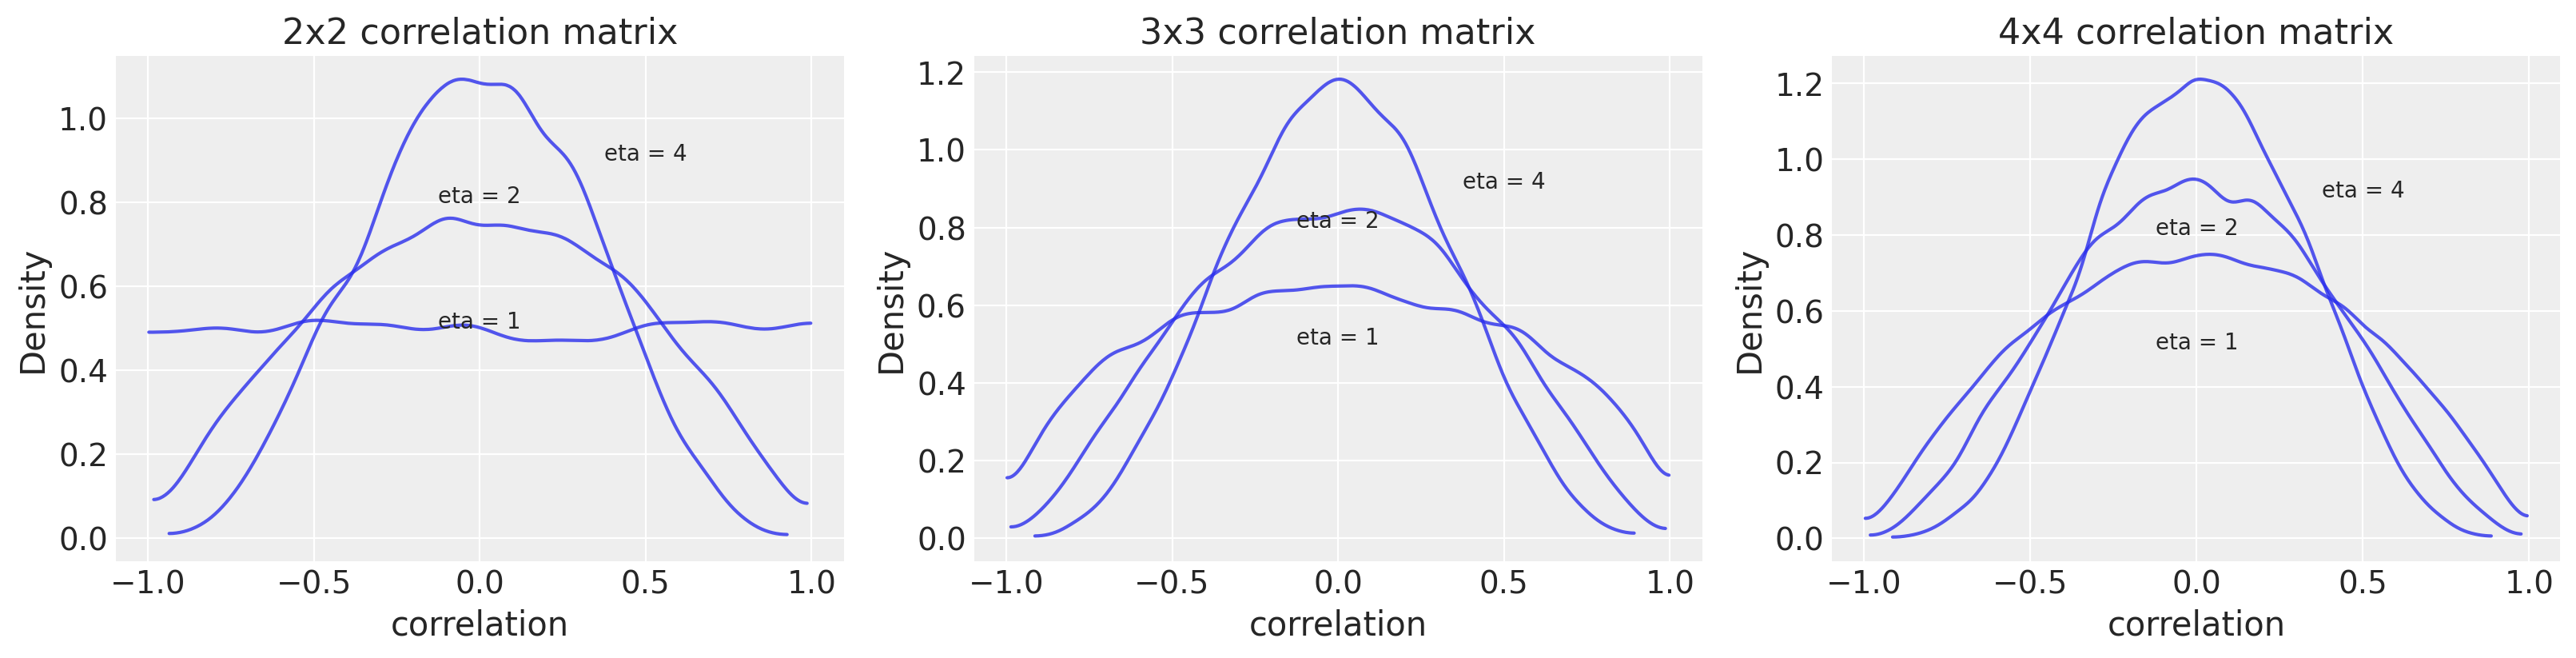

<IPython.core.display.Javascript object>

In [6]:
# repo code (for correlation matrix of 2x2)
f, ax = plt.subplots(1, 3, figsize=(16, 4))
textloc = [[0, 0.5], [0, 0.8], [0.5, 0.9]]

for i in range(3):
    for eta, loc in zip([1, 2, 4], textloc):
        R = pm.LKJCorr.dist(n=i+2, eta=eta).random(size=10000)
        az.plot_kde(R, plot_kwargs={"alpha": 0.8}, ax=ax[i])
        ax[i].text(loc[0], loc[1], "eta = %s" % (eta), horizontalalignment="center")

    ax[i].set_xlabel("correlation")
    ax[i].set_ylabel("Density")
    ax[i].set_title(f"{i+2}x{i+2} correlation matrix");

 You can see that an `eta` value of 2 is fairly conservative with most of the expectation for correlations being low. The size of the correlation matrix itself also influences the distribution, particularly at the tails.

# Manually building a covariance matrix

Remember that at this point we don't have the covariance matrix yet. We only have sampled *correlation* matrices. But we can get the covariance matrix once we take some sampled sigmas. Let's do that to see how this would look in 5 draws from a prior distribution. We wouldn't do this for a real problem. This is just to demonstrate what sampling would look like, step-by-step. We'll go back to a 2x2 covariance matrix to make things simple.

For each pass through this loop, we will:
- take one rho value, since this is a 2x2 corelation matrix
- take two standard deviation (sigma) values and they'll be from slightly different distributions just to make things interesting (Exp(1) and Exp(0.5))
- arrange the sigmas as a vector
- generate a new covariance matrix from the rho and sigmas
- output the covariance matrix and the values that 


In [7]:
for i in range(5):
    # the [0] is just to get the value out of the array
    rho = pm.LKJCorr.dist(n=2, eta=2).random(size=1)[0][0]
    Rmat = np.array([[1, rho], [rho, 1]])
    # the sigmas themselves need to be sampled; again the [0] is to get the value out of the array
    sigma_a = pm.Exponential.dist(1.0).random(size=1)[0]
    sigma_b = pm.Exponential.dist(0.5).random(size=1)[0]
    sigmas = np.array([sigma_a, sigma_b])  # arrange the sigmas as a vector
    Sigma = np.diag(sigmas).dot(Rmat).dot(np.diag(sigmas))   # use a weird way a that covariance matrix is made
    print(f"sample {i}\n -- sigma for a: {sigma_a:0.3f},\t sigma for b: {sigma_b:0.3f},\tRho: {rho:0.3f} \n -- covariance matrix:\n{Sigma}\n")

sample 0
 -- sigma for a: 0.411,	 sigma for b: 2.389,	Rho: -0.289 
 -- covariance matrix:
[[ 0.16873355 -0.28350151]
 [-0.28350151  5.7070884 ]]

sample 1
 -- sigma for a: 1.969,	 sigma for b: 10.462,	Rho: 0.436 
 -- covariance matrix:
[[  3.87629967   8.97898901]
 [  8.97898901 109.46212826]]

sample 2
 -- sigma for a: 1.932,	 sigma for b: 2.676,	Rho: -0.404 
 -- covariance matrix:
[[ 3.73187298 -2.08904139]
 [-2.08904139  7.1588578 ]]

sample 3
 -- sigma for a: 0.601,	 sigma for b: 2.326,	Rho: 0.233 
 -- covariance matrix:
[[0.36063857 0.32606953]
 [0.32606953 5.41025897]]

sample 4
 -- sigma for a: 3.659,	 sigma for b: 0.002,	Rho: 0.458 
 -- covariance matrix:
[[1.33858317e+01 4.08000425e-03]
 [4.08000425e-03 5.92186930e-06]]



<IPython.core.display.Javascript object>

# `LKJCholeskyCov` distribution

Unlike `LKJCorr`, there's no `.dist` method that we can sample from directly. However, we can wrap this in a model container and sample from it. Again, this is not recommended practice. It is merely to get an idea of what this function is producing. Check out the [pymc example](https://docs.pymc.io/en/v3/pymc-examples/examples/case_studies/LKJ.html) I referenced above for an authoritative source.

(One difference compared to the manual way of constructing the covariance matrix above is that I don't think there's a way to specify different prior distributions for the sigmas in the `sd_dist` parameter, at least with version 3.11.0 of `pymc`.)

In [8]:
with pm.Model() as m1:
    packed_L = pm.LKJCholeskyCov("packed_L",  eta=2, n=2, sd_dist=pm.Exponential.dist(1.0))
    trace_m1 = pm.sample(1000, tune=1000, return_inferencedata=False, progressbar=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [packed_L]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4781781973772051, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.705022869734104, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


<IPython.core.display.Javascript object>

In [9]:
pm.trace_to_dataframe(trace_m1).head()

,packed_L__0,packed_L__1,packed_L__2
0,2.248979,-1.339856,2.574068
1,1.521427,-1.494167,1.882593
2,2.729876,-1.076162,2.427225
3,0.781399,-0.943537,1.931551
4,1.161240,-0.111627,0.320429


<IPython.core.display.Javascript object>

With each sample, we have three values. They are a lower triangular matrix but they are *not* of the covariance matrix itself. Rahter, they are the **Cholesky decomposition** of the covariance matrix. For practical purposes and for interpretation, it is better to use the following instantiation where we can get the rho and sigma values back automatically.

In [10]:
with pm.Model() as m2:
    chol, corr, stds = pm.LKJCholeskyCov(
        "chol", n=2, eta=2.0, sd_dist=pm.Exponential.dist(1.0), compute_corr=True
    )
    cov = pm.Deterministic("cov", chol.dot(chol.T))
    trace_m2 = pm.sample(1000, tune=1000, return_inferencedata=False, progressbar=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [chol]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.47696968632616427, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6910481731222186, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5735096676868859, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective sam

<IPython.core.display.Javascript object>

In [11]:
trace_m2_df = pm.trace_to_dataframe(trace_m2)
trace_m2_df.head()

,chol__0,chol__1,chol__2,chol_stds__0,chol_stds__1,chol_corr__0_0,chol_corr__0_1,chol_corr__1_0,chol_corr__1_1,cov__0_0,cov__0_1,cov__1_0,cov__1_1
0,3.622728,-0.515597,1.710626,3.622728,1.786640,1.0,-0.288585,-0.288585,1.0,13.124155,-1.867867,-1.867867,3.192082
1,0.697870,-0.172701,1.485430,0.697870,1.495436,1.0,-0.115485,-0.115485,1.0,0.487023,-0.120523,-0.120523,2.236328
2,0.600202,0.428665,1.425867,0.600202,1.488909,1.0,0.287906,0.287906,1.0,0.360242,0.257286,0.257286,2.216850
3,1.777497,-0.023333,0.703293,1.777497,0.703680,1.0,-0.033159,-0.033159,1.0,3.159494,-0.041475,-0.041475,0.495165
4,0.671842,-0.077284,0.361800,0.671842,0.369962,1.0,-0.208898,-0.208898,1.0,0.451371,-0.051923,-0.051923,0.136872


<IPython.core.display.Javascript object>

We can verify the values of the covariance matrix by using the standard deviations and correlation coefficients of the posterior.

In [12]:
for i in range(5):
    sigmas = trace_m2_df.loc[i, ['chol_stds__0', 'chol_stds__1']]
    rho = trace_m2_df.loc[i, 'chol_corr__0_1']
    Rmat = np.array([[1, rho], [rho, 1]])
    Sigma = np.diag(sigmas).dot(Rmat).dot(np.diag(sigmas))
    print(f'draw: {i}', Sigma, sep='\n')

draw: 0
[[13.12415508 -1.86786674]
 [-1.86786674  3.19208164]]
draw: 1
[[ 0.48702298 -0.1205228 ]
 [-0.1205228   2.23632763]]
draw: 2
[[0.36024213 0.25728563]
 [0.25728563 2.21685039]]
draw: 3
[[ 3.15949443 -0.0414752 ]
 [-0.0414752   0.49516542]]
draw: 4
[[ 0.45137105 -0.05192275]
 [-0.05192275  0.13687202]]


<IPython.core.display.Javascript object>

Compare the printed values from each sample draw and you see that we get an exact match with the `cov__0_0`, `cov__0_1`, `cov__1_0`, and `cov__1_1` columns.

# Summary

In this post, I wanted to better understand the `LKJcorr` and `LKJcov` outputs. You often wouldn't have to go this detailed, but it helped me gain a better understanding of using and interpreting these distributions when applied to problems with multivariate normals, including varying effects models.

In [13]:
%watermark -n -u -v -iv -w

Last updated: Tue Apr 12 2022

Python implementation: CPython
Python version       : 3.8.6
IPython version      : 7.20.0

seaborn   : 0.11.1
matplotlib: 3.3.4
pymc3     : 3.11.0
scipy     : 1.6.0
theano    : 1.1.0
pandas    : 1.2.1
numpy     : 1.20.1
sys       : 3.8.6 | packaged by conda-forge | (default, Jan 25 2021, 23:22:12) 
[Clang 11.0.1 ]
arviz     : 0.11.1

Watermark: 2.1.0



<IPython.core.display.Javascript object>